In [43]:
import os
import numpy as np
from PIL import Image, ImageFilter
import cv2
import torch,torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
!pip install session-info


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 8.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=f8bfd4ad840da802ef186d46b48ca2148a4a56428c5a1f7d07673b17f92b466d
  Stored in directory: /root/.cache/pip/wheels/d4/fc/2e/00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [44]:
import session_info
session_info.show()

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
torch.cuda.is_available()

True

In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import os

ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomImageFolder(datasets.ImageFolder):
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and not d.name.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def custom_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.custom_loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

def load_data(path, test_split, val_split, batch_size, input_size):
    
    transform_dict = {'src': transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.RandomVerticalFlip(),
                      transforms.RandomRotation(15),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                      ])}

    data1 = CustomImageFolder(root=path, transform=transform_dict['src'])
    test_size = int(len(data1) * test_split)
    val_size = int(len(data1) * val_split)
    train_size = len(data1) - val_size - test_size

    train_dataset, test_dataset, val_dataset = torch.utils.data.random_split(data1, [train_size, test_size, val_size])
    data_loader_train = DataLoader(train_dataset, batch_size, shuffle=True)
    data_loader_test = DataLoader(test_dataset, batch_size, shuffle=False)
    data_loader_val = DataLoader(val_dataset, batch_size, shuffle=False)

    return data_loader_train, data_loader_test, data_loader_val



In [28]:
path = "/content/datasets/"
train_loader, test_loader, val_loader = load_data(path=path,
                                                  test_split=0.1,
                                                  val_split=0.1,
                                                  batch_size=16,
                                                  input_size=[224, 224])


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6843 samples in 0.029s...
[t-SNE] Computed neighbors for 6843 samples in 30.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6843
[t-SNE] Computed conditional probabilities for sample 2000 / 6843
[t-SNE] Computed conditional probabilities for sample 3000 / 6843
[t-SNE] Computed conditional probabilities for sample 4000 / 6843
[t-SNE] Computed conditional probabilities for sample 5000 / 6843
[t-SNE] Computed conditional probabilities for sample 6000 / 6843
[t-SNE] Computed conditional probabilities for sample 6843 / 6843
[t-SNE] Mean sigma: 1860.890071
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.644508
[t-SNE] KL divergence after 300 iterations: 3.124996


<ipython-input-33-b0b6d82d05e9>:21: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=Y, palette=sns.color_palette("hls", 6), legend="full")


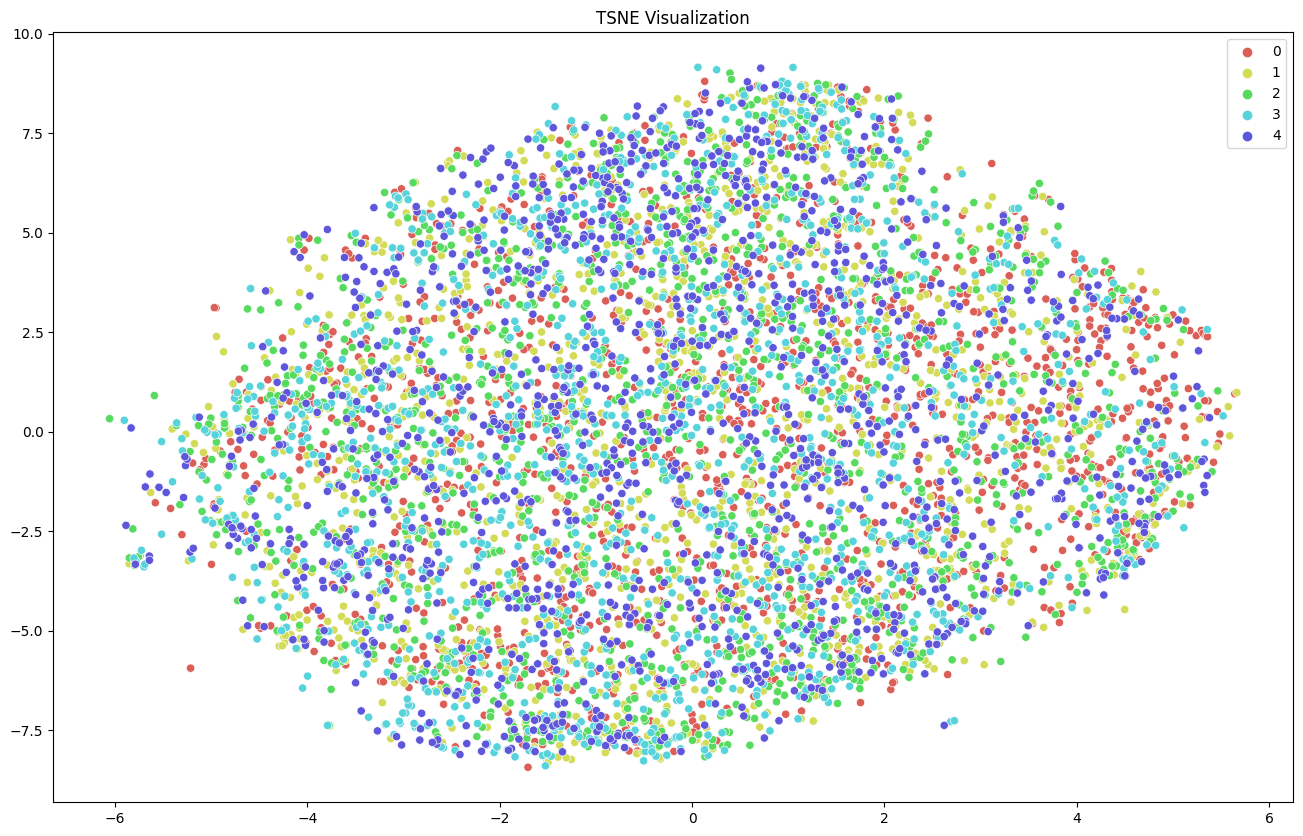

In [33]:
data = CustomImageFolder(root="/content/datasets/")
random=0
X=[]
Y=[]
for x,y in data:
    xrs=x.resize((64,64))
    img=np.array(xrs).reshape(64*64*3)
    X.append(img)
    Y.append(y)
arrX=np.array(X)
arrY=np.array(Y)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(arrX)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=Y, palette=sns.color_palette("hls", 6), legend="full")
plt.title('TSNE Visualization')
plt.show()

plt.close()


In [34]:
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False, num_classes = 5)


optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [35]:
num_epochs = 50
train_losses = []
train_accs = []
val_accs = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        val_loss = 0.0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        val_loss /= len(val_loader.dataset) #Val loss and acc for each epoch
        val_acc = 100 * correct / total
        
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

Epoch 1/50, Train Loss: 1.6655, Train Accuracy: 20.18%, Validation Loss: 0.1011, Validation Accuracy: 21.49%
Epoch 2/50, Train Loss: 1.6077, Train Accuracy: 21.63%, Validation Loss: 0.1025, Validation Accuracy: 19.59%
Epoch 3/50, Train Loss: 1.6030, Train Accuracy: 23.34%, Validation Loss: 0.1008, Validation Accuracy: 23.39%
Epoch 4/50, Train Loss: 1.5975, Train Accuracy: 25.22%, Validation Loss: 0.1003, Validation Accuracy: 21.20%
Epoch 5/50, Train Loss: 1.6040, Train Accuracy: 21.79%, Validation Loss: 0.1015, Validation Accuracy: 17.69%
Epoch 6/50, Train Loss: 1.5908, Train Accuracy: 24.84%, Validation Loss: 0.1006, Validation Accuracy: 23.83%
Epoch 7/50, Train Loss: 1.5905, Train Accuracy: 23.98%, Validation Loss: 0.1017, Validation Accuracy: 18.71%
Epoch 8/50, Train Loss: 1.5842, Train Accuracy: 25.86%, Validation Loss: 0.0994, Validation Accuracy: 24.85%
Epoch 9/50, Train Loss: 1.5775, Train Accuracy: 25.94%, Validation Loss: 0.0991, Validation Accuracy: 23.83%
Epoch 10/50, Train 

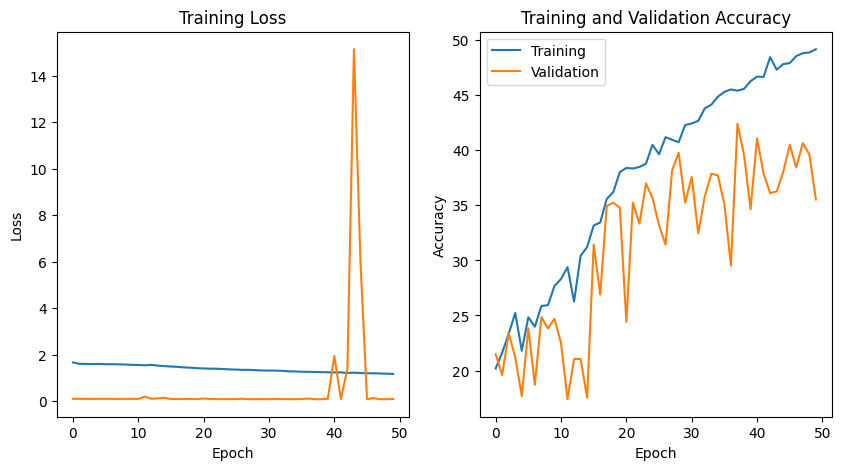

In [36]:
# Plot training accuracy and loss
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses,label='Training')
plt.plot(val_losses, label='Validation')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_accs, label='Training')
plt.plot(val_accs, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
# Evaluation on test set and ROC curve
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # For ROC curve
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy())  # Predicted probabilities for all classes

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy}')
# Save the model
torch.save(model.state_dict(), 'UTKFace-ShuffleNet.pth')

Test Accuracy: 34.941520467836256


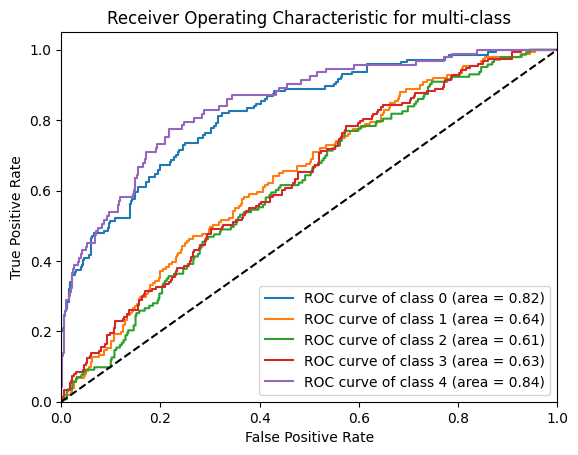

In [47]:
# Assuming 'model' is your trained classifier and 'val_loader' contains the validation data
y_pred_proba_list = []
y_true_list = []

with torch.no_grad():
    model.eval()
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        y_pred_raw = model(images)
        y_pred_proba_batch = torch.softmax(y_pred_raw, dim=1)
        y_pred_proba_list.append(y_pred_proba_batch.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

# Convert the predicted probabilities to NumPy arrays
y_pred_proba = np.concatenate(y_pred_proba_list, axis=0)
y_true = np.concatenate(y_true_list, axis=0)

# Binarize the true labels
n_classes = 5  # Number of classes in your problem
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()



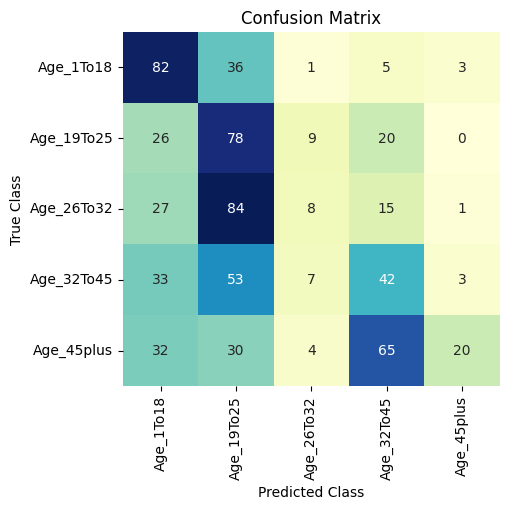

In [49]:
#confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_true = []
y_pred = []
for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_true.extend(labels.cpu().numpy())

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())

cf_matrix = confusion_matrix(y_true, y_pred)
class_names = ('Age_1To18', 'Age_19To25', 'Age_26To32', 'Age_32To45', 'Age_45plus')
 
# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(5, 5))
 
# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
 
plt.title("Confusion Matrix"), plt.tight_layout()
 
plt.ylabel("True Class"),
plt.xlabel("Predicted Class")
plt.show()